In [103]:
from datetime import datetime
import pandas as pd
import numpy as np

In [104]:
tp = pd.read_csv("Result_Wait-4.csv", iterator=True, chunksize=1000)
df = pd.concat(tp, ignore_index=True)

df['time'] = df['time'].apply(lambda x: datetime.strptime(x, '%d-%b-%Y %H:%M:%S'))
df['date'] = df['time'].apply(lambda x: x.strftime("%Y/%m/%d"))
# df['detail_time'] = df['time'].apply(lambda x: x.strftime("%H:%M:%S"))
df['detail_time'] = df['time'].apply(lambda x: x.time())
df['weekday'] = df['time'].apply(lambda x: x.strftime('%A'))

In [105]:
df.head(5)

,posture,x,y,speed,week,ind,traitement,breed,time,temperature,date,detail_time,weekday
0,3,3.861676,92.686224,0.000000,5,200002,1,0,2020-08-19 08:30:00,29.0,2020/08/19,08:30:00,Wednesday
1,3,5.414635,87.580417,5.336754,5,200002,1,0,2020-08-19 08:30:30,29.0,2020/08/19,08:30:30,Wednesday
2,3,7.015623,99.617082,12.142671,5,200002,1,0,2020-08-19 08:31:00,29.0,2020/08/19,08:31:00,Wednesday
3,4,93.993134,155.479983,103.371907,5,200002,1,0,2020-08-19 08:31:30,29.0,2020/08/19,08:31:30,Wednesday
4,4,131.654742,82.356483,82.252313,5,200002,1,0,2020-08-19 08:32:00,29.5,2020/08/19,08:32:00,Wednesday


In [106]:
def drop_nan(df):
    print('nan:', df[df['ind'].isna()])
    df = df.dropna()
    df['ind'] = df['ind'].astype(int).astype(str)
    print(df.shape)
    return df

df = drop_nan(df)
# agg_df = drop_nan(agg_df)
# adj_df = drop_nan(adj_df)

nan: Empty DataFrame
Columns: [posture, x, y, speed, week, ind, traitement, breed, time, temperature, date, detail_time, weekday]
Index: []
(537350, 13)


In [132]:
adj_df[adj_df['ind'] != 200002]

,ind,posture,x,y,speed,traitement,breed,temperature,time,200002,...,204926,204927,204938,204945,204946,num_nb,degree,close,bet,pr
0,200002,4.0,11.978012,70.496874,0.000000,1.0,0.0,29.0,2020-06-24 08:30:00,False,...,True,False,True,False,True,6.0,0.750000,0.800000,0.119048,0.133792
1,200002,3.0,88.959491,134.882619,9.047293,1.0,0.0,29.0,2020-06-24 09:00:00,False,...,True,True,True,True,True,7.0,0.777778,0.818182,0.052778,0.108011
2,200002,5.0,80.451316,125.843261,3.072955,1.0,0.0,29.0,2020-06-24 09:30:00,False,...,True,True,True,True,True,9.0,1.000000,1.000000,0.073148,0.137479
3,200002,4.0,9.492997,69.291319,1.218399,1.0,0.0,29.0,2020-06-24 10:00:00,False,...,False,True,True,False,True,5.0,0.555556,0.692308,0.043519,0.085345
4,200002,5.0,42.256037,134.660285,9.000454,1.0,0.0,29.0,2020-06-24 10:30:00,False,...,True,True,True,True,True,9.0,1.000000,1.000000,0.100794,0.146425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45785,204946,5.0,126.220773,16.877291,0.481381,0.0,1.0,28.0,2020-09-27 15:30:00,True,...,True,True,False,True,False,7.0,NaN,NaN,NaN,NaN
45786,204946,5.0,123.087031,5.944065,1.829531,0.0,1.0,28.0,2020-09-27 16:00:00,False,...,False,True,False,True,False,5.0,NaN,NaN,NaN,NaN
45787,204946,5.0,98.695865,21.413136,5.450935,0.0,1.0,28.0,2020-09-27 16:30:00,False,...,False,False,True,True,False,4.0,NaN,NaN,NaN,NaN
45788,204946,5.0,102.857665,36.064586,1.938851,0.0,1.0,28.0,2020-09-27 17:00:00,False,...,False,False,True,False,False,3.0,NaN,NaN,NaN,NaN


In [107]:
timestamp = df['time'].unique()
pid_list = df['ind'].unique()

predict = ['posture']
feature = ['x', 'y', 'speed', 'traitement', 'breed', 'temperature']
feature_df = ['ind', 'posture', 'x', 'y', 'speed', 'traitement', 'breed', 'temperature', 'time']
agg_time = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq="30min")

# data
data = None #np.empty((len(timestamp), len(pid_list), len(feature)))
adj = np.zeros((len(agg_time), len(pid_list), len(pid_list)))
agg_df = None

for p_idx, _pid in enumerate(pid_list):
       filter_B = df['ind'] == _pid
       select_pig = df[ filter_B ].set_index('time').resample("30min").ffill()
       select_pig['time'] = select_pig.index
       select_pig.index = range(len(select_pig))
       row = select_pig[feature].to_numpy() #.ravel()

       # label
       y_row = pd.get_dummies(select_pig['posture'])
       # y_row[np.isnan(y_row)] = 1
       
       row = np.expand_dims(row, axis=1)
       # print(row.shape)
       y_row = np.expand_dims(y_row, axis=1)

       if row.shape[0] == 0:
              data[:][p_idx] =  np.empty(len(feature))
              y_truth[t_idx][p_idx] = np.nan
              print('row nan')
       else:
              if data is None:
                     data = row
                     y_truth = y_row
                     agg_df = select_pig[feature_df]
              else:
                     data = np.concatenate((data, row), axis=1)
                     y_truth = np.concatenate((y_truth, y_row), axis=1)
                     agg_df = pd.concat([agg_df, select_pig[feature_df]])
       for p_idx_2, _pid_2 in enumerate(pid_list):
              filter_C = df['ind'] == _pid_2
              select_pig_2 = df[ filter_C ].set_index('time').resample("30min").ffill()

              first_x = select_pig['x'].values
              first_y = select_pig['y'].values

              sec_x = select_pig_2['x'].values
              sec_y = select_pig_2['y'].values

              dist = (first_x - sec_x) ** 2 + (first_y - sec_y) ** 2
              dist = dist ** 0.5
              adj[:, p_idx, p_idx_2] = dist

# turn the label to dummy
agg_df.index = range(len(agg_df))

# output
print(data.shape, y_truth.shape, adj.shape)

(4579, 10, 6) (4579, 10, 5) (4579, 10, 10)


In [108]:
import networkx as nx

def cal_centrality(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)

    # G is the Karate Club Graph 
    deg_centrality = nx.degree_centrality(G) 
    # print(deg_centrality) 

    # G is the Karate Social Graph 
    close_centrality = nx.closeness_centrality(G)   
    # print(close_centrality) 

    # G is the Karate Social Graph, parameters normalized 
    # and endpoints ensure whether we normalize the value 
    # and consider the endpoints respectively. 
    bet_centrality = nx.betweenness_centrality(G, normalized = True,  
                                                  endpoints = False) 
    # print(bet_centrality) 

    # G is the Karate Social Graph 
    pr = nx.pagerank(G, alpha = 0.8) 
    # print(pr) 
    return deg_centrality, close_centrality, bet_centrality, pr

test = cal_centrality(adj[0] > 70)

# Plot the Distribution
## Distance

c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0
248.51142530045942
44.70420316361433
71.61170726689063
71.61170726689063


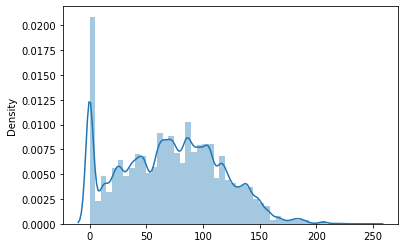

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(adj)
result = np.reshape(adj, -1)
result = result[~np.isnan(result)]
print(min(result))
print(max(result))
print(np.std(result))
print(np.mean(result))
print(np.average(result))
plt.savefig("figure/dis_distance.png")

c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


24.5
37.0
2.015069790729261
29.595939331906578
29.595939331906578


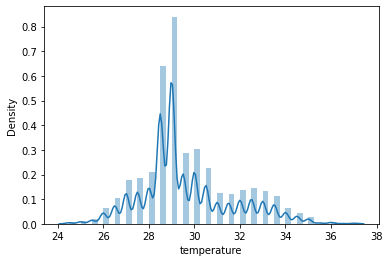

In [110]:
sns.distplot(df['temperature'])
plt.savefig("figure/dis_temperature.png")
print(min(df['temperature']))
print(max(df['temperature']))
print(np.std(df['temperature']))
print(np.mean(df['temperature']))
print(np.average(df['temperature']))

c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0
268.514643164298
22.726220839710038
13.57179610996268
13.57179610996268


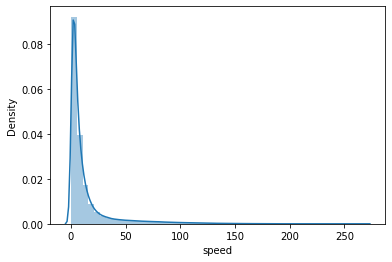

In [111]:
sns.distplot(df['speed'])
plt.savefig("figure/dis_speed.png")
print(min(df['speed']))
print(max(df['speed']))
print(np.std(df['speed']))
print(np.mean(df['speed']))
print(np.average(df['speed']))

In [112]:
def format_df(cen_dict):
    for i in range(10):
        if i in cen_dict.keys():
            cen_dict[i] = [cen_dict[i]]
        else:
            cen_dict[i] = [0]
    result = pd.DataFrame(cen_dict)
    result = result.reindex(sorted(result.columns), axis=1)
    return result

deg_df = None
close_df  = None
bet_df = None
pr_df = None

for adj_row in adj:
    deg, close, bet, pr = cal_centrality(adj_row > 70)
    if deg_df is None:
        deg_df = format_df(deg)
        close_df = format_df(close)
        bet_df = format_df(bet)
        pr_df = format_df(pr)
    else:
        deg_df = pd.concat([deg_df, format_df(deg)], ignore_index=True)
        close_df = pd.concat([close_df, format_df(close)], ignore_index=True)
        bet_df = pd.concat([bet_df, format_df(bet)], ignore_index=True)
        pr_df = pd.concat([pr_df, format_df(pr)], ignore_index=True)

print(deg_df.head(5))

          0         1         2         3         4         5         6  \
0  0.750000  0.500000  0.500000  0.625000  0.000000  0.375000  0.750000   
1  0.777778  0.777778  0.888889  0.666667  0.555556  0.666667  0.444444   
2  1.000000  0.666667  0.777778  0.666667  0.555556  0.777778  0.666667   
3  0.555556  0.777778  0.555556  0.666667  0.777778  0.777778  0.666667   
4  1.000000  0.666667  0.444444  0.777778  0.444444  0.555556  0.444444   

          7         8         9  
0  0.500000  0.750000  0.750000  
1  0.888889  0.666667  0.777778  
2  0.555556  0.666667  0.555556  
3  0.555556  0.777778  0.777778  
4  0.777778  0.777778  0.555556  


c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

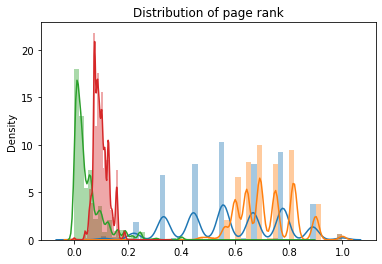

In [113]:
def plot_cen(df, name):
    plt.title(f"Distribution of {name}")
    sns.distplot(df)
    plt.savefig(f"figure/dis_{name}.png")

centrality = [deg_df, close_df, bet_df, pr_df]
cen_name = ['degree centrality',
            'close centrality',
            'betweeness centrality',
            'page rank']
for i in range(4):
    plot_cen(centrality[i], cen_name[i])

In [114]:
print(deg_df.shape)
print(close_df.shape)
print(bet_df.shape)
print(pr_df.shape)

(4579, 10)
(4579, 10)
(4579, 10)
(4579, 10)


In [133]:
pid_list

array(['200002', '200004', '200011', '200013', '200014', '204926',
       '204927', '204938', '204945', '204946'], dtype=object)

In [169]:
num_row = 4579

adj_df = agg_df

for p_id in pid_list:
    adj_df[p_id] = 0

for i, p_id in enumerate(pid_list):
    # adjacency
    link = adj[:, i]
    linked = link > 70
    # print(linked.shape, adj_df.loc[num_row * i: num_row *(i+1)-1, pid_list].shape)
    # print(f'{num_row * i} : {num_row * (i+1)-1}')
    adj_df.loc[num_row * i : num_row * (i+1)-1, pid_list] = linked
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'num_nb'] = np.sum(linked, axis=1)

    # centrality
    # print(f'{num_row * i} : {num_row * (i+1)-1}:', deg_df[i])
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'degree'] = deg_df[i].values
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'close'] = close_df[i].values
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'bet'] = bet_df[i].values
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'pr'] = pr_df[i].values
    
print(adj_df.head(5))

      ind  posture          x           y     speed  traitement  breed  \
0  200002      4.0  11.978012   70.496874  0.000000         1.0    0.0   
1  200002      3.0  88.959491  134.882619  9.047293         1.0    0.0   
2  200002      5.0  80.451316  125.843261  3.072955         1.0    0.0   
3  200002      4.0   9.492997   69.291319  1.218399         1.0    0.0   
4  200002      5.0  42.256037  134.660285  9.000454         1.0    0.0   

   temperature                time 200002  ... 204926 204927 204938 204945  \
0         29.0 2020-06-24 08:30:00  False  ...   True  False   True  False   
1         29.0 2020-06-24 09:00:00  False  ...   True   True   True   True   
2         29.0 2020-06-24 09:30:00  False  ...   True   True   True   True   
3         29.0 2020-06-24 10:00:00  False  ...  False   True   True  False   
4         29.0 2020-06-24 10:30:00  False  ...   True   True   True   True   

  204946 num_nb    degree     close       bet        pr  
0   True    6.0  0.750000  0

In [171]:
def turn_dummy(data_df, col_name):
    # label
    label_oh = pd.get_dummies(data_df[col_name].astype(int), prefix=col_name)
    data_df = data_df.drop(col_name, axis=1)
    data_df = data_df.join(label_oh)
    # print(data_df.head(5))
    return data_df

# drop nan
agg_df = drop_nan(agg_df)
adj_df = drop_nan(adj_df)

# agg_df = turn_dummy(agg_df, 'posture')
# adj_df = turn_dummy(adj_df, 'posture')

nan:        ind  posture   x   y  speed  traitement  breed  temperature  \
18316  NaN      NaN NaN NaN    NaN         NaN    NaN          NaN   

                     time 200002  ... 204926 204927 204938 204945 204946  \
18316 2020-06-24 08:30:00  False  ...  False  False  False  False  False   

      num_nb degree close  bet   pr  
18316    0.0    0.0   0.0  0.0  0.0  

[1 rows x 24 columns]
(45789, 24)
nan:        ind  posture   x   y  speed  traitement  breed  temperature  \
18316  NaN      NaN NaN NaN    NaN         NaN    NaN          NaN   

                     time 200002  ... 204926 204927 204938 204945 204946  \
18316 2020-06-24 08:30:00  False  ...  False  False  False  False  False   

      num_nb degree close  bet   pr  
18316    0.0    0.0   0.0  0.0  0.0  

[1 rows x 24 columns]
(45789, 24)


c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [199]:
adj_df['ind'].unique()

array(['200002', '200004', '200011', '200013', '200014', '204926',
       '204927', '204938', '204945', '204946'], dtype=object)

In [172]:
# adj_df = adj_df.drop('ind', axis=1)
adj_df.shape

(45789, 24)

In [173]:
import pysubgroup as ps

# Load the example dataset
from pysubgroup.datasets import get_titanic_data
# data = get_titanic_data()
output_path = 'C:\\Users\\Gina\\Lab\\exchange\\subgroup'
for i in range(1, 6):
    print(f"target value: {i}")

    target = ps.BinaryTarget ('posture', target_value=i)
    searchspace = ps.create_selectors(adj_df, ignore=['posture'])
    task = ps.SubgroupDiscoveryTask(
        adj_df,
        target,
        searchspace,
        result_set_size=5,
        depth=2,
        qf=ps.WRAccQF())
    result = ps.DFS().execute(task)
    result.to_dataframe().to_csv(f"{output_path}/adj_posture_{i}.csv")
    
    print('-'*20)


target value: 1
--------------------
target value: 2
--------------------
target value: 3
--------------------
target value: 4
--------------------
target value: 5
--------------------


In [22]:
result.to_dataframe()

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.091144,speed: [4.28:19.89[,916,4579,648,1153,3663,0.200044,0.799956,0.562012,0.437988,0.707424,0.137865,0.251802,2.809447
1,0.091144,speed: [4.28:19.89[ AND traitement==1.0,916,4579,648,1153,3663,0.200044,0.799956,0.562012,0.437988,0.707424,0.137865,0.251802,2.809447
2,0.091144,breed==0.0 AND speed: [4.28:19.89[,916,4579,648,1153,3663,0.200044,0.799956,0.562012,0.437988,0.707424,0.137865,0.251802,2.809447
3,0.091144,200002==False AND speed: [4.28:19.89[,916,4579,648,1153,3663,0.200044,0.799956,0.562012,0.437988,0.707424,0.137865,0.251802,2.809447
4,0.090089,204927==True,2071,4579,934,1153,2508,0.452282,0.547718,0.810061,0.189939,0.450990,0.087321,0.251802,1.791052


In [174]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [175]:
adj_df.columns

Index(['ind', 'posture', 'x', 'y', 'speed', 'traitement', 'breed',
       'temperature', 'time', '200002', '200004', '200011', '200013', '200014',
       '204926', '204927', '204938', '204945', '204946', 'num_nb', 'degree',
       'close', 'bet', 'pr'],
      dtype='object')

In [176]:
X = adj_df.drop(['posture', 'time'], axis=1)
y = adj_df['posture']

In [177]:
# 將字串標籤轉換為整數
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 資料拆分成training set, testing set和validation set
# 使用 y_encoded 作為目標變數
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [178]:
X_train

,ind,x,y,speed,traitement,breed,temperature,200002,200004,200011,...,204926,204927,204938,204945,204946,num_nb,degree,close,bet,pr
39481,204945,9.561951,65.835728,1.609899,1.0,1.0,28.5,True,True,False,...,True,True,False,False,True,7.0,0.777778,0.818182,0.069246,0.121441
28305,204927,53.311714,130.024162,9.603163,1.0,1.0,29.0,True,True,False,...,True,False,False,False,True,5.0,0.555556,0.692308,0.026389,0.093269
8416,200004,100.939809,67.570412,4.371622,0.0,0.0,28.5,False,False,False,...,True,False,False,False,False,2.0,0.222222,0.562500,0.004630,0.056537
790,200002,106.773524,154.879477,75.408342,1.0,0.0,29.0,False,False,False,...,True,False,False,True,True,4.0,0.500000,0.666667,0.027381,0.108508
32338,204938,115.722968,119.014950,1.306280,1.0,1.0,29.0,False,False,True,...,True,False,False,True,True,5.0,0.555556,0.692308,0.014385,0.087454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,200011,87.652727,50.884189,14.903933,1.0,0.0,31.5,False,False,False,...,False,False,False,True,False,3.0,0.333333,0.600000,0.000000,0.060073
44733,204946,119.178756,44.848719,14.257705,0.0,1.0,29.5,True,True,False,...,True,False,True,False,False,4.0,0.444444,0.642857,0.007440,0.071792
38159,204945,12.526954,77.623751,1.748343,1.0,1.0,29.5,True,False,True,...,True,True,True,False,True,7.0,0.777778,0.818182,0.118981,0.130275
860,200002,139.591903,92.535210,3.305515,1.0,0.0,29.0,False,True,False,...,True,True,False,True,False,6.0,0.666667,0.750000,0.049537,0.100842


In [179]:
# 建立Random Forest模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [180]:
# 預測
y_pred = rf_model.predict(X_val)
# 評估模型
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Set Accuracy: {accuracy}')
# 最後，使用測試集進行最終評估
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Set Accuracy: {test_accuracy}')
print(classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.9012813046010484
Test Set Accuracy: 0.9065366137720192
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       720
           1       0.92      0.94      0.93      2240
           2       1.00      0.91      0.95       485
           3       0.94      0.93      0.93      2197
           4       0.80      0.87      0.83      1227

    accuracy                           0.91      6869
   macro avg       0.91      0.89      0.90      6869
weighted avg       0.91      0.91      0.91      6869



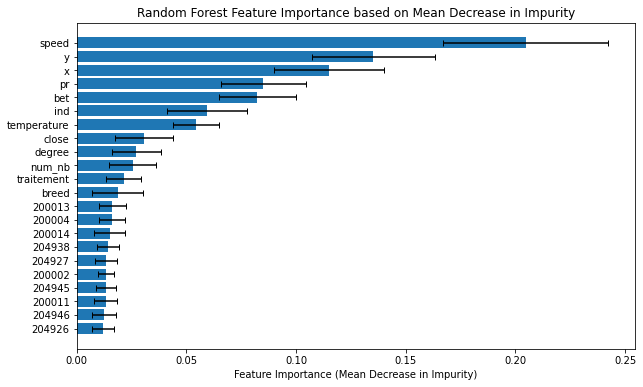

In [181]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# 獲取特徵名稱
feature_names = X.columns

# 建立一個包含特徵名稱、其對應重要性和標準差的 DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Std': std})

# 依照重要性降序排列
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# 將特徵名稱轉換為字符串
feature_names = feature_importance_df['Feature'].astype(str)

# 繪製條形圖
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance_df['Importance'], xerr=feature_importance_df['Std'], capsize=3)
plt.xlabel('Feature Importance (Mean Decrease in Impurity)')
plt.title('Random Forest Feature Importance based on Mean Decrease in Impurity')
plt.savefig('RF_FeatureImportance_2.png')
plt.show()

## Update the data with condition

### For Posture 1

In [187]:
sel_name = 'bet<0.01'
selector = (adj_df['bet'] < 0.01)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 204927==False AND bet<0.01	
sel_name = '204927==False AND bet<0.01'
selector = (adj_df['204927'] == False) & (adj_df['bet'] < 0.01)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 200002==False AND bet<0.01	
sel_name = '200002==False AND bet<0.01'
selector = (adj_df['200002'] == False) & (adj_df['bet'] < 0.01)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 200004==False AND bet<0.01	
sel_name = '200004==False AND bet<0.01'
selector = (adj_df['200004'] == False) & (adj_df['bet'] < 0.01)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# ind=='204945'	
sel_name = 'ind==204945'
selector = (adj_df['ind'] == '204945') 
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

### For posture 2

In [190]:
# breed==1.0 AND traitement==0.0	
sel_name = 'breed==1.0 AND traitement==0.0'
selector = (adj_df['breed'] == 1.0) & (adj_df['traitement'] == 0.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 200014==True AND traitement==0.0	
sel_name = '200014==True AND traitement==0.0'
selector = (adj_df['200014'] == True) & (adj_df['traitement'] == 0.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 200004==True AND traitement==0.0	
sel_name = '200004==True AND traitement==0.0'
selector = (adj_df['200004'] == True) & (adj_df['traitement'] == 0.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# close>=0.82 AND traitement==0.0	
sel_name = 'close>=0.82 AND traitement==0.0'
selector = (adj_df['close'] >=0.82 ) & (adj_df['traitement'] ==0.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# num_nb>=7.0 AND traitement==0.
sel_name = 'num_nb>=7.0 AND traitement==0.0'
selector = (adj_df['num_nb'] >= 7.0) & (adj_df['traitement'] == 0.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

### For posture 3

In [191]:
# traitement==1.0 AND y: [34.22:53.93[	
sel_name = 'traitement==1.0 AND y: [34.22:53.93['
selector = (adj_df['traitement'] == 1.0) & (adj_df['y'] >= 34.22) & (adj_df['y'] <= 53.93)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# y: [34.22:53.93[	
sel_name = 'y: [34.22:53.93['
selector = (adj_df['y'] >= 34.22) & (adj_df['y'] <= 53.93)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# temperature: [29.0:29.50[ AND y: [34.22:53.93[
sel_name = 'temperature: [29.0:29.50[ AND y: [34.22:53.93['
selector = (adj_df['temperature'] >= 29.0) & (adj_df['temperature'] <= 29.5) & (adj_df['y'] >= 34.22) & (adj_df['y'] <= 53.93)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# ind=='204927' AND y: [34.22:53.93[
sel_name = 'ind==204927 AND y: [34.22:53.93['
selector = (adj_df['ind'] == '204927')  & (adj_df['y'] >= 34.22) & (adj_df['y'] <= 53.93)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# speed: [3.95:6.97[ AND y: [34.22:53.93[
sel_name = 'speed: [3.95:6.97[ AND y: [34.22:53.93['
selector = (adj_df['speed'] >= 3.95) & (adj_df['speed'] <= 6.97) & (adj_df['y'] >= 34.22) & (adj_df['y'] <= 53.93)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

### For posture 4

In [193]:
# speed>=18.31
sel_name = 'speed>=18.31'
selector = (adj_df['speed'] >= 18.31)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 204926==True AND speed>=18.31
sel_name = '204926==True AND speed>=18.31'
selector = (adj_df['204926'] == True) & (adj_df['speed'] >= 18.31)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 200014==True AND speed>=18.31	
sel_name = '200014==True AND speed>=18.31'
selector = (adj_df['200014'] == True) & (adj_df['speed'] >= 18.31)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# speed>=18.31 AND traitement==1.0		
sel_name = 'speed>=18.31 AND traitement==1.0'
selector = (adj_df['speed'] >= 18.31) & (adj_df['traitement'] == 1.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 200004==False AND speed>=18.31
sel_name = '200004==False AND speed>=18.31'
selector = (adj_df['200004'] == False) & (adj_df['speed'] >=18.31)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

### For posture 5

In [194]:
# 200004==False AND 204946==True		
sel_name = '200004==False AND 204946==True'
selector = (adj_df['200004'] == False) & (adj_df['204946'] == True)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 200013==True AND 204946==True	
sel_name = '200013==True AND 204946==True'
selector = (adj_df['200013'] == True) & (adj_df['204946'] == True)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 204927==True AND breed==0.0	
sel_name = '204927==True AND breed==0.0'
selector = (adj_df['204927'] == True) & (adj_df['breed'] == 0.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# 204946==True AND breed==0.0
sel_name = '204946==True AND breed==0.0'
selector = (adj_df['204946'] == True) & (adj_df['breed'] == 0.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

# breed==0.0	
sel_name = 'breed==0.0'
selector = (adj_df['breed'] == 0.0)
adj_df.loc[selector, sel_name] = 1
adj_df.loc[~selector, sel_name] = 0

c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [195]:
adj_df.columns

Index(['ind', 'posture', 'x', 'y', 'speed', 'traitement', 'breed',
       'temperature', 'time', '200002', '200004', '200011', '200013', '200014',
       '204926', '204927', '204938', '204945', '204946', 'num_nb', 'degree',
       'close', 'bet', 'pr', 'bet<0.01', '204927==False AND bet<0.01',
       '200002==False AND bet<0.01', '200004==False AND bet<0.01',
       'ind==204945', 'breed==1.0 AND traitement==0.0',
       '200014==True AND traitement==0.0', '200004==True AND traitement==0.0',
       'close>=0.82 AND traitement==0.0', 'num_nb>=7.0 AND traitement==0.0',
       'traitement==1.0 AND y: [34.22:53.93[', 'y: [34.22:53.93[',
       'temperature: [29.0:29.50[ AND y: [34.22:53.93[',
       'ind==204927 AND y: [34.22:53.93[',
       'speed: [3.95:6.97[ AND y: [34.22:53.93[', 'speed>=18.31',
       '204926==True AND speed>=18.31', '200014==True AND speed>=18.31',
       'speed>=18.31 AND traitement==1.0', '200004==False AND speed>=18.31',
       '200004==False AND 204946==True', '2

In [196]:
adj_df.to_csv('data/data_agg_30Min_with_subgroup.csv')

In [197]:
adj_df.columns

Index(['ind', 'posture', 'x', 'y', 'speed', 'traitement', 'breed',
       'temperature', 'time', '200002', '200004', '200011', '200013', '200014',
       '204926', '204927', '204938', '204945', '204946', 'num_nb', 'degree',
       'close', 'bet', 'pr', 'bet<0.01', '204927==False AND bet<0.01',
       '200002==False AND bet<0.01', '200004==False AND bet<0.01',
       'ind==204945', 'breed==1.0 AND traitement==0.0',
       '200014==True AND traitement==0.0', '200004==True AND traitement==0.0',
       'close>=0.82 AND traitement==0.0', 'num_nb>=7.0 AND traitement==0.0',
       'traitement==1.0 AND y: [34.22:53.93[', 'y: [34.22:53.93[',
       'temperature: [29.0:29.50[ AND y: [34.22:53.93[',
       'ind==204927 AND y: [34.22:53.93[',
       'speed: [3.95:6.97[ AND y: [34.22:53.93[', 'speed>=18.31',
       '204926==True AND speed>=18.31', '200014==True AND speed>=18.31',
       'speed>=18.31 AND traitement==1.0', '200004==False AND speed>=18.31',
       '200004==False AND 204946==True', '2